# Sparkify Project Workspace

## Introduction

This project explores a music streaming application called "Sparkify". We have a dataset that contains data related to the app. users and their activities within the app. In this project, we will be working on a small subset of the data to explore different features and build a machine learning model to predict churn. 

We can define churn as the activity when a user submits a "Cancellation Confirmation" request.

#### Data Description

- ts : timestamp, when this event was recorded in miliseconds
- userId : identifier unique for each user, can be empty
- firstname : firstname of user, like “Colin”
- lastname : lastname of user, like “Freeman”
- location : city like “Bakersfield, CA”
- gender : “F” for female, “M” for male
- registration : timestamp of subscription
- level : can be “free” or “paid”
- page : Webpage visited, or button clicked, e.g. “NextSong”, “Thumbs Up”, “Logout”, “Downgrade”, …)
- method : HTTP Method “GET” or “POST”
- status : HTTP Response Code “200”, “307”, “404”
- userAgent : browser used, like “Mozilla/5.0 …(Win…) Firefox/31.0”
- sessionId : numeric session id for grouping session events
- itemInSession : number of this event in the user session
- auth : current status of authentication “Logged In”, “Logged Out“, …
- song : title of song, like “Time For Miracles”
- length : length of song in seconds with decimals “277.89016”
- artist : artist performing the song, like “Adam Lambert”

Souce: https://medium.com/@ferenc.hechler/sparkify-customer-satisfaction-prediction-f3b0941e8710

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import dayofweek, avg, col, concat, first, when, round, desc, month, hour, from_unixtime, unix_timestamp, date_format, explode, lit, min, max, split, udf, count, sum
from pyspark.sql.functions import sum as Fsum
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from xgboost.spark import SparkXGBClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import re
import datetime
from pyspark.sql import Window

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# Apply the changes to the current session
import os
os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.driver.extraJavaOptions=-Dlog4j.logger.org.apache.spark=ERROR pyspark-shell"

import logging
logging.getLogger("py4j").setLevel(logging.ERROR)

## Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 
We will load and clean the dataset, and check for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Override user-defined log settings
spark.sparkContext.setLogLevel("ERROR")  # Options: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN

/opt/venv/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/18 09:06:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# read the data
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# Check schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Take a look at the head
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
# Check data length
df.count()

286500

Let's start by dropping un-needed columns. Some columns include user data (firstName, lastName), I believe we don't need these columns since we already have the unique identifier "userId".

In [8]:
df = df.drop('firstName', 'lastName')

In [9]:
# check missing values count
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).collect()

[Row(artist=58392, auth=0, gender=8346, itemInSession=0, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [10]:
# check missing values percent (rounded to 2)
df.select([round(100*sum(col(c).isNull().cast("int")/df.count()), 2).alias(c) for c in df.columns]).collect()

[Row(artist=20.38, auth=0.0, gender=2.91, itemInSession=0.0, length=20.38, level=0.0, location=2.91, method=0.0, page=0.0, registration=2.91, sessionId=0.0, song=20.38, status=0.0, ts=0.0, userAgent=2.91, userId=0.0)]

Columns "artist", "song" & "length" have the highest % of missing values (20.38%), followed by other columns like gender & location with a small % (2.91%).

In [11]:
# let's see if we have duplicated data
df.count() - df.distinct().count()

0

Good! We don't have duplicated rows.

In [12]:
# Next, let's check invalid data

df.select("userId").dropDuplicates().sort("userId").show(3)

+------+
|userId|
+------+
|      |
|    10|
|   100|
+------+
only showing top 3 rows



It seems that userId column have blank values. Let's drop them

In [13]:
# Check blank count
df.select(df.userId).where(df.userId=='').count()

8346

In [14]:
# Drop blank rows
df = df.filter(df.userId!='')
df.count()

278154

In [15]:
# let's double-check invalid data
df.select("userId").dropDuplicates().sort("userId").show(3)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
+------+
only showing top 3 rows



Now let's check blank values in "sessionId" column

In [16]:
df.select("sessionId").dropDuplicates().sort("sessionId").show(3)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
+---------+
only showing top 3 rows



"sessionId" column doesn't have blank values.

In [17]:
# Convert ts column to a readable format
df = df.withColumn('timestamp', from_unixtime(col("ts") / 1000, "yyyy-MM-dd HH:mm:ss"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57')

In [18]:
# Convert registration column to a readable format
df = df.withColumn('registration_ts', from_unixtime(col("registration") / 1000, "yyyy-MM-dd HH:mm:ss"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', registration_ts='2018-09-28 22:22:42')

In [19]:
# drop ts & registration columns
df = df.drop("registration", "ts")
df.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', registration_ts='2018-09-28 22:22:42')

In [20]:
# Rename column to original name
df = df.withColumnRenamed("registration_ts", "registration")
df.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', registration='2018-09-28 22:22:42')

In [21]:
# Calculate the difference in # days
df = df.withColumn("Duration", (unix_timestamp(col("timestamp")) - unix_timestamp(col("registration")))/86400)
df.head()

Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', registration='2018-09-28 22:22:42', Duration=2.068923611111111)

# Exploratory Data Analysis

### Define Churn

Now let's create a column `Churn` to use as the label for our model. 

We can define churn using the `Cancellation Confirmation` value from the "page" column.

In [22]:
# Check different values in "page" column
df.select("page").dropDuplicates().sort("page").take(5)

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation')]

In [23]:
# Create a function to map churn values to "page" column values
churn_flag = udf(lambda x:1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [24]:
# Add churn column
df = df.withColumn("churn", churn_flag("page"))

In [25]:
# Ensure "churn" column values are correct
df.select(["page", 'churn']).where(df.page=="Cancellation Confirmation").show(3)

+--------------------+-----+
|                page|churn|
+--------------------+-----+
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
+--------------------+-----+
only showing top 3 rows



There are multiple rows for every user. We only marked one of them with churn value 1 which is the row with page value "Cancellation Confirmation", now we should update the remaining rows for the same user who churned with value 1 in the churn column. Since the last activity for churned users are "Cancellation Confirmation", we can update all preceeding rows with churn value 1 if the last page value = "Cancellation Confirmation"

In [26]:
# Extract userID for some churners to check the validity of assumption
df.select(['timestamp', 'userId','churn']).where(df.churn==1).show(3)

+-------------------+------+-----+
|          timestamp|userId|churn|
+-------------------+------+-----+
|2018-10-07 20:26:30|    18|    1|
|2018-10-08 21:10:46|    32|    1|
|2018-10-12 04:35:18|   125|    1|
+-------------------+------+-----+
only showing top 3 rows



In [27]:
# Ensure last page activity for churners is "Cancellation Confirmation"
df.select(['timestamp', 'userId','churn','page']).where(df.userId==18).tail(5)

[Row(timestamp='2018-10-07 20:17:20', userId='18', churn=0, page='NextSong'),
 Row(timestamp='2018-10-07 20:22:06', userId='18', churn=0, page='NextSong'),
 Row(timestamp='2018-10-07 20:22:19', userId='18', churn=0, page='Downgrade'),
 Row(timestamp='2018-10-07 20:22:20', userId='18', churn=0, page='Cancel'),
 Row(timestamp='2018-10-07 20:26:30', userId='18', churn=1, page='Cancellation Confirmation')]

Perfect! let's change the values of churn column from 0 to 1 for all churners.

In [28]:
# Define the window
from pyspark.sql import functions as F

# Define the window to get the last row for each user
churn_window = Window.partitionBy("userId").orderBy(F.desc("timestamp"))

# Get the churn value of the last row for each user
last_churn_value = F.last("churn", ignorenulls=True).over(churn_window)

# Update the churn column based on the condition that the last churn is 1
df = df.withColumn("churn", F.when(last_churn_value == 1, 1).otherwise(F.col("churn")))

churners = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [29]:
# Apply window
df = df.withColumn("churn_flag", max(col("churn")).over(churners))

In [30]:
# drop churn column
df = df.drop("churn")

In [31]:
# Rename column with the original name
df = df.withColumnRenamed("churn_flag", "churn")

### Explore Data

Now let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

In [32]:
# Calculate number of unique users
df.select(["userId"]).dropDuplicates().count()

225

In [33]:
# Calculate number of unique churners vs non-churners
churn_ratios = df.select(["userId", "churn"]).dropDuplicates().groupby("churn").count()
churn_ratios.show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



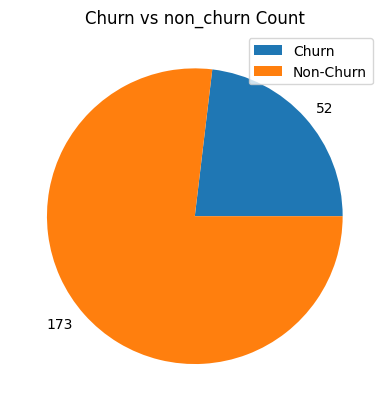

In [34]:
# plot churn #
pd_ratios = churn_ratios.toPandas()
plt.pie(pd_ratios['count'], labels=[pd_ratios['count'][0],pd_ratios['count'][1]])
plt.title("Churn vs non_churn Count")
plt.legend(["Churn","Non-Churn"]);

In [35]:
# Gender distribution vs churn
gender = df.select(["userId", "churn","Gender"]).dropDuplicates()

df_pivot = gender.groupBy("churn").pivot("Gender").count().fillna(0)
df_pivot.show()

+-----+---+---+
|churn|  F|  M|
+-----+---+---+
|    1| 20| 32|
|    0| 84| 89|
+-----+---+---+



In [36]:
# level distribution vs churn
level = df.select(["userId", "churn","level"]).dropDuplicates()

df_pivot2 = level.groupBy("churn").pivot("level").count().fillna(0)
df_pivot2.show()

+-----+----+----+
|churn|free|paid|
+-----+----+----+
|    1|  46|  36|
|    0| 149| 129|
+-----+----+----+



We notice that the total number of records in both churn and non-churn is more than the total unique users. I assume that this is because some users exist 2 times in the level dataframe, one with the free level and one with the paid level. Let's validate this assumption

In [37]:
# Validate my assumption
level.select(["userId", "churn","level"]).sort('userId').show(10)

+------+-----+-----+
|userId|churn|level|
+------+-----+-----+
|    10|    0| paid|
|   100|    0| paid|
|   100|    0| free|
|100001|    1| free|
|100002|    0| paid|
|100003|    1| free|
|100004|    0| paid|
|100004|    0| free|
|100005|    1| free|
|100006|    1| free|
+------+-----+-----+
only showing top 10 rows



Our assumption is correct. Let's visualize the data knowing that some users will exist twice in both "Free" & "Paid", we are mainly interested in checking the count of free vs paid subscriptions.

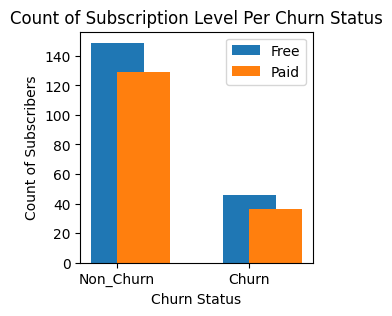

In [38]:
# Visualize level vs churn

pd_level = df_pivot2.toPandas()
plt.figure(figsize=(3, 3))
plt.bar(pd_level['churn'], pd_level['free'], label='Free', width=0.4)
plt.bar(pd_level['churn']+0.2, pd_level['paid'], label='Paid', width=0.4)
plt.title("Count of Subscription Level Per Churn Status")
plt.xticks([0,1], ["Non_Churn", "Churn"])
plt.xlabel("Churn Status")
plt.ylabel("Count of Subscribers")
plt.legend();

In [39]:
# length average per churn
df.select(['length', 'churn']).groupby("churn").avg().show()

+-----+------------------+----------+
|churn|       avg(length)|avg(churn)|
+-----+------------------+----------+
|    1|248.63279564406207|       1.0|
|    0|249.20913538881047|       0.0|
+-----+------------------+----------+



Average length is nearly the same for both churners and non-churners. 

Now let's explore the number of songs in each group. But first, let's understand what is the values in "Song" column when "Page" values differ.

In [40]:
df.select(['song', 'userId', 'page']).dropDuplicates(['page']).show(20)

+---------+------+--------------------+
|     song|userId|                page|
+---------+------+--------------------+
|     NULL|    39|               About|
|     NULL|   101|          Add Friend|
|     NULL|    30|     Add to Playlist|
|     NULL|    18|              Cancel|
|     NULL|    18|Cancellation Conf...|
|     NULL|    54|           Downgrade|
|     NULL|   131|               Error|
|     NULL|   101|                Help|
|     NULL|     9|                Home|
|     NULL|     9|              Logout|
|Rockpools|    30|            NextSong|
|     NULL|     9|         Roll Advert|
|     NULL|    81|       Save Settings|
|     NULL|    95|            Settings|
|     NULL|   131|    Submit Downgrade|
|     NULL|   142|      Submit Upgrade|
|     NULL|     9|         Thumbs Down|
|     NULL|     9|           Thumbs Up|
|     NULL|     9|             Upgrade|
+---------+------+--------------------+



It seems that song names appear when the page value is "NextSong", while othe page values usually accompany a "Null" value in the song column.

In [41]:
# Calculate the count of unique songs per user for both churn and non-churn
songs = df.select(['churn', 'song', 'userId']).where(df.song!="NULL").dropDuplicates()

songs.groupBy("churn").agg({"song":"count"}).show()

+-----+-----------+
|churn|count(song)|
+-----+-----------+
|    1|      33195|
|    0|     168808|
+-----+-----------+



In [42]:
songs.show(5)

+-----+--------------------+------+
|churn|                song|userId|
+-----+--------------------+------+
|    0|        Summer Storm|    10|
|    0|              Canada|    10|
|    0|On Green Dolphin ...|    10|
|    0|Sunshine (Feat. A...|    10|
|    0|               Hello|    10|
+-----+--------------------+------+
only showing top 5 rows



In [43]:
# Average number of songs listened to by each group
songs_per_user = songs.groupBy("userId", "churn").agg(count("song").alias("total_songs"))
songs_per_user.groupBy("churn").agg(avg("total_songs").alias("avg_songs")).show()

+-----+-----------------+
|churn|        avg_songs|
+-----+-----------------+
|    1|638.3653846153846|
|    0|975.7687861271677|
+-----+-----------------+



On average, churners listen to less # of songs than non-churners.

In [44]:
# Earliest date in the data
df.agg(min("timestamp")).collect()[0][0]

'2018-10-01 00:01:57'

In [45]:
# Latest date in the data
df.agg(max("timestamp")).collect()[0][0]

'2018-12-03 01:11:16'

let's see the churn # per hour

In [46]:
# Extract hour data from timestamp
df = df.withColumn("hour", hour(df.timestamp))

In [47]:
# Number of churn cases per hour
churn_per_hour = df.select(['churn', 'hour']).where(df.page=='Cancellation Confirmation')
churn_per_hour.groupBy("hour").agg({"churn": "count"}).sort(desc("count(churn)")).show()

+----+------------+
|hour|count(churn)|
+----+------------+
|   7|           6|
|  19|           5|
|  16|           4|
|  15|           4|
|  22|           3|
|  20|           3|
|  21|           3|
|   0|           3|
|  18|           3|
|  12|           2|
|   3|           2|
|  17|           2|
|   4|           2|
|  11|           2|
|   1|           1|
|  13|           1|
|   5|           1|
|   8|           1|
|  23|           1|
|  10|           1|
+----+------------+
only showing top 20 rows



Maximum # of churn cases happened at 7:00 AM

In [48]:
# Calculate the number of songs played per hour
hours = df.select(["userId","song","hour"]).where(df.song!="NULL").dropDuplicates().groupBy(df.hour).agg({"song":"count"}).orderBy(desc('count(song)'))
hours.show()

+----+-----------+
|hour|count(song)|
+----+-----------+
|  16|      11503|
|  17|      11326|
|  15|      11235|
|  18|      11007|
|  19|      10785|
|  20|      10726|
|  14|      10380|
|  21|      10346|
|  22|      10027|
|  13|       9563|
|  23|       9532|
|  12|       9239|
|   0|       8985|
|  10|       8788|
|  11|       8765|
|   9|       8404|
|   1|       8305|
|   3|       8291|
|   2|       8249|
|   8|       8182|
+----+-----------+
only showing top 20 rows



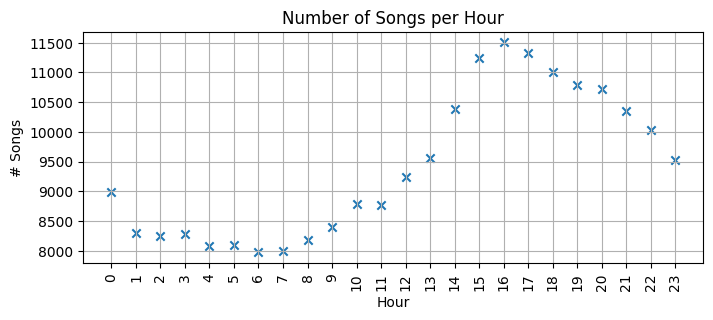

In [49]:
# Visualize # songs/hour:

pd_hour = hours.toPandas()
plt.figure(figsize=(8,3))
plt.scatter(pd_hour['hour'], y=pd_hour['count(song)'], marker='x')
plt.title("Number of Songs per Hour")
plt.xlabel("Hour")
plt.ylabel("# Songs")
plt.xticks(list(pd_hour['hour']), rotation=90)
plt.grid(True);

Peak time is from 03:00 PM to 06:00 PM

In [50]:
# Extract day of week data from timestamp
df = df.withColumn("dow", dayofweek(df.timestamp))

In [51]:
# Check Day of week in which churn happened
dow = df.select(['userId', 'churn', 'dow']).dropDuplicates(['userId', 'churn']).where(df.churn==1)
dow_data = dow.groupBy('dow').pivot('churn').count().orderBy("dow")
dow_data.show()

+---+---+
|dow|  1|
+---+---+
|  1|  5|
|  2|  9|
|  3|  6|
|  4|  7|
|  5|  5|
|  6| 13|
|  7|  7|
+---+---+



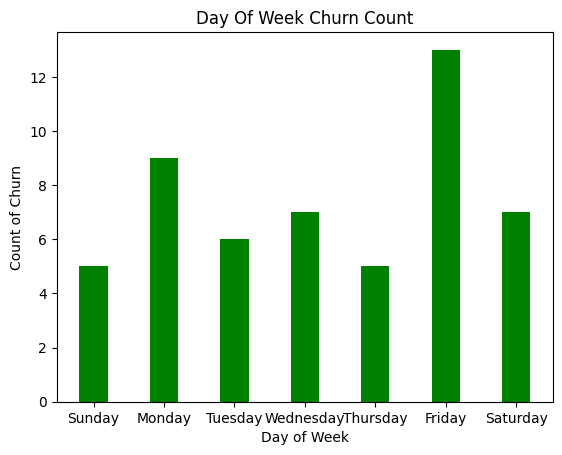

In [52]:
# Visualize the data
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
pd_dow = dow_data.toPandas()
plt.bar(pd_dow['dow'], pd_dow['1'], width=0.4, color='green')
plt.title("Day Of Week Churn Count")
plt.xlabel('Day of Week')
plt.ylabel("Count of Churn")
plt.xticks(pd_dow['dow'], days);

It seems that most churn cases happeed on Friday

In [53]:
# Let's visualize # songs per day of week
week_trend = df.select(['userId', 'dow', 'song']).where(df.song!="NULL").groupBy(df.dow).agg({'song':'count'})
week_trend.show()

+---+-----------+
|dow|count(song)|
+---+-----------+
|  1|      17370|
|  6|      39514|
|  3|      38830|
|  5|      36300|
|  4|      37675|
|  7|      23046|
|  2|      35373|
+---+-----------+



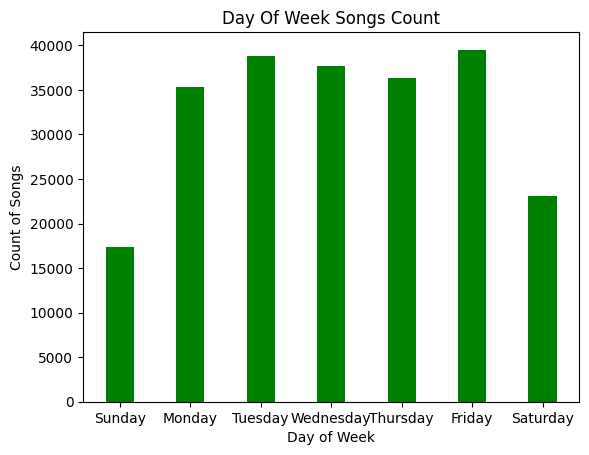

In [54]:
# Visualize week_trend
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
pd_week_trend = week_trend.toPandas()
plt.bar(pd_week_trend['dow'], pd_week_trend['count(song)'], width=0.4, color='green')
plt.title("Day Of Week Songs Count")
plt.xlabel('Day of Week')
plt.ylabel("Count of Songs")
plt.xticks(pd_dow['dow'], days);

Sunday seems to be the day with least # of sogs played, while the peak day is Friday.

In [55]:
# Average subscription duration for churners vs non-churners
sub_duration = df.select(['userId', 'churn','duration']).dropDuplicates(['userId', 'churn'])
sub_duration.groupBy('churn').agg({"duration":"avg"}).show()

+-----+-----------------+
|churn|    avg(duration)|
+-----+-----------------+
|    1|57.30599292200855|
|    0|86.62061938021833|
+-----+-----------------+



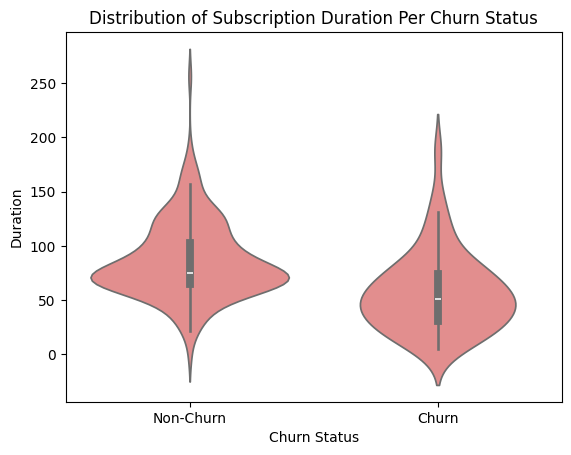

In [85]:
# Visualize the duration
pd_duration = sub_duration.toPandas()
sns.violinplot(x='churn', y='duration', data=pd_duration, color='lightcoral')
plt.title("Distribution of Subscription Duration Per Churn Status")
plt.xlabel('Churn Status')
plt.ylabel("Duration")
plt.xticks([0, 1], ['Non-Churn', 'Churn']);

Non-churners have higher duration (# of days) in subscription.

In [56]:
# Check the top 5 locations between subscribers
loc = df.select(['userId','location']).dropDuplicates(['userId'])
loctions = loc.groupBy('location').agg({"location":"count"}).orderBy(desc("count(location)"))
loctions.take(5)

[Row(location='Los Angeles-Long Beach-Anaheim, CA', count(location)=16),
 Row(location='New York-Newark-Jersey City, NY-NJ-PA', count(location)=15),
 Row(location='Phoenix-Mesa-Scottsdale, AZ', count(location)=7),
 Row(location='Dallas-Fort Worth-Arlington, TX', count(location)=7),
 Row(location='St. Louis, MO-IL', count(location)=6)]

In [57]:
# Convert to pandas df to visualize
pd_locations = loctions.toPandas().sort_values(by='count(location)', ascending=True)
pd_locations.head()

,location,count(location)
56,"Dayton, OH",1
82,"Oklahoma City, OK",1
81,"North Wilkesboro, NC",1
80,"Bozeman, MT",1
79,"Austin-Round Rock, TX",1


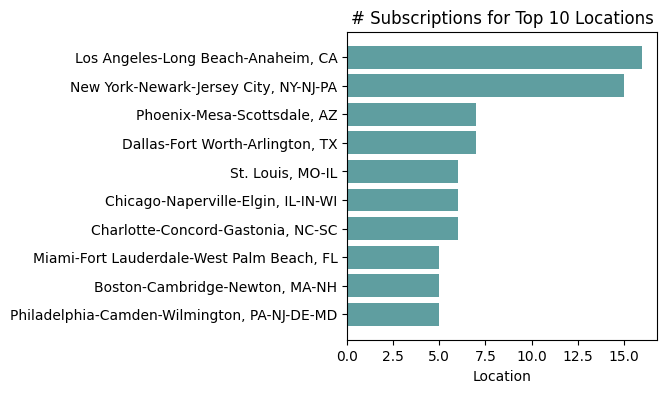

In [58]:
# Visualize the top 10 locations count
plt.figure(figsize=(4,4))
plt.barh(y=pd_locations['location'][-10:], width=pd_locations['count(location)'][-10:], color='cadetblue')
plt.xlabel("Count of Subscriptions")
plt.xlabel("Location")
plt.title("# Subscriptions for Top 10 Locations");

Los Angeles & New York have the highest number of subscribers

In [59]:
# Check userAgent column data
df.select('userAgent').dropDuplicates().count()

56

In [60]:
df.select('userAgent').dropDuplicates().take(5)

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"')]

We have 56 different values, each value contains operating system data (Windows or Mac), and also browser data (Chrome or Safari). Let's extract this information into 2 new columns

In [61]:
from pyspark.sql.functions import regexp_extract

# Regular expressions to extract OS and Browser
os_regex = r'\(([^;]+)'  # Extracts first word inside parentheses (OS)
browser_regex = r'(\w+)/[\d.]+.*?(\w+)/[\d.]+.*?(\w+)/[\d.]+'  

# Create new columns
df = df.withColumn("OperatingSystem", regexp_extract("userAgent", os_regex, 1)) \
       .withColumn("Browser", regexp_extract("userAgent", browser_regex, 3))

In [62]:
# Check the operatingSystems counts
system = df.select(['userId','OperatingSystem','churn']).dropDuplicates(['userId', 'churn'])
system.groupBy('OperatingSystem').pivot("churn").count().orderBy(desc("0")).fillna(0).show(20)

+--------------------+---+---+
|     OperatingSystem|  0|  1|
+--------------------+---+---+
|           Macintosh| 67| 19|
|      Windows NT 6.1| 59| 16|
|      Windows NT 6.3| 11|  5|
|              iPhone|  9|  4|
|                 X11|  7|  5|
|          compatible|  5|  0|
|Windows NT 5.1) A...|  4|  0|
|                iPad|  3|  0|
|      Windows NT 6.2|  3|  1|
|Windows NT 6.1) A...|  3|  1|
|Windows NT 6.1) A...|  1|  0|
|      Windows NT 6.0|  1|  0|
|Windows NT 5.1) A...|  0|  1|
+--------------------+---+---+



In [63]:
# Check the browser counts
browser = df.select(['userId','Browser','churn']).dropDuplicates(['userId', 'churn'])
browser_data = browser.groupBy('Browser').pivot("churn").count().orderBy(desc("0"))
browser_data.show(20)

+-------+---+---+
|Browser|  0|  1|
+-------+---+---+
| Chrome| 92| 25|
|Version| 36| 10|
|Firefox| 34| 16|
|       | 11|  1|
+-------+---+---+



The most popular operating system is Macintosh, and most popular browser is Chrome.

We notice a row with missing browser name, let's try to find out the operating system of these browsers

In [64]:
df.select(['userId','Browser','churn','OperatingSystem']).where(df.Browser=="").dropDuplicates(['userId', 'churn']).show(100)

+------+-------+-----+---------------+
|userId|Browser|churn|OperatingSystem|
+------+-------+-----+---------------+
|100004|       |    0|     compatible|
|    11|       |    0| Windows NT 6.1|
|   147|       |    0|     compatible|
|    19|       |    0| Windows NT 6.1|
|    22|       |    0| Windows NT 6.1|
|    28|       |    1| Windows NT 6.1|
|300003|       |    0| Windows NT 6.1|
|300011|       |    0|     compatible|
|300025|       |    0| Windows NT 6.1|
|    41|       |    0|     compatible|
|    84|       |    0| Windows NT 6.1|
|    93|       |    0|     compatible|
+------+-------+-----+---------------+



We can see that "compatible" & "Windows NT 6.1" operating systems have blank browser values. Let's check if they have other non-blank browsers.

In [65]:
df.select(['Browser', 'OperatingSystem']).where((df.OperatingSystem=="compatible") | (df.OperatingSystem=="Windows NT 6.1")).dropDuplicates().show(10)

+-------+---------------+
|Browser|OperatingSystem|
+-------+---------------+
|       |     compatible|
| Chrome| Windows NT 6.1|
|       | Windows NT 6.1|
|Firefox| Windows NT 6.1|
+-------+---------------+



We can see that Operating System "compatible" does not have a browser name, while "Windows NT 6.1" Operating System has multiple browsers in addition to the blank value.

Let's skip the blank values from our plot.

In [66]:
# Convert to pandas to plot and exclude blank row
pd_browser = browser_data.toPandas().iloc[:3,:]
pd_browser

,Browser,0,1
0,Chrome,92,25
1,Version,36,10
2,Firefox,34,16


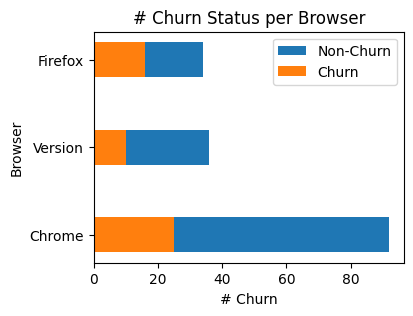

In [67]:
# Visualize the data
plt.figure(figsize=(4,3))
plt.barh(y=pd_browser['Browser'], width=pd_browser['0'], height=0.4, label='Non-Churn')
plt.barh(y=pd_browser['Browser'], width=pd_browser['1'], height=0.4, label='Churn')
plt.title("# Churn Status per Browser")
plt.ylabel("Browser")
plt.xlabel('# Churn')
plt.legend();

In [68]:
# Drop the userAgent column
df = df.drop("userAgent")

Next, Let's explore the "Page" column values

In [69]:
df.select(df.page).dropDuplicates().show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



I believe that for each user, we need to extract the total number of the below values:
- Submit Downgrade
- Thumbs Down
- Add to Playlist
- Add Friend
- Thumbs Up
- Help
- Error
- Submit Upgrade

Let's group the data by each of these values

In [70]:
Submit_downgrade = df.select(df.userId, df.page).where(df.page=='Submit Downgrade').groupby(df.userId).count().\
                withColumnRenamed("count", 'Submit_downgrade')
Submit_downgrade.show(5)

+------+----------------+
|userId|Submit_downgrade|
+------+----------------+
|    54|               1|
|    11|               1|
|    30|               1|
|    59|               1|
|    85|               2|
+------+----------------+
only showing top 5 rows



In [71]:
thumbsdown = df.select(df.userId, df.page).where(df.page=='Thumbs Down').groupby(df.userId).count().\
                withColumnRenamed("count", 'Thumbs_Down')
thumbsdown.show(5)

+------+-----------+
|userId|Thumbs_Down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows



In [72]:
add2playlist = df.select(df.userId, df.page).where(df.page=='Add to Playlist').groupby(df.userId).count().\
                withColumnRenamed("count", 'Add_to_Playlist')
add2playlist.show(5)

+------+---------------+
|userId|Add_to_Playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows



In [73]:
add_friend = df.select(df.userId, df.page).where(df.page=='Add Friend').groupby(df.userId).count().\
                withColumnRenamed("count", 'Add_Friend')
add_friend.show(5)

+------+----------+
|userId|Add_Friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



In [74]:
thumbsup = df.select(df.userId, df.page).where(df.page=='Thumbs Up').groupby(df.userId).count().\
                withColumnRenamed("count", 'Thumbs_Up')
thumbsup.show(5)

+------+---------+
|userId|Thumbs_Up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows



In [75]:
help_count = df.select(df.userId, df.page).where(df.page=='Help').groupby(df.userId).count().\
                withColumnRenamed("count", 'Help_Count')
help_count.show(5)

+------+----------+
|userId|Help_Count|
+------+----------+
|100010|         2|
|200002|         2|
|    51|        12|
|   124|        23|
|     7|         1|
+------+----------+
only showing top 5 rows



In [76]:
error_count = df.select(df.userId, df.page).where(df.page=='Error').groupby(df.userId).count().\
                withColumnRenamed("count", 'Error_count')
error_count.show(5)

+------+-----------+
|userId|Error_count|
+------+-----------+
|   124|          6|
|    51|          1|
|     7|          1|
|    15|          2|
|    54|          1|
+------+-----------+
only showing top 5 rows



In [77]:
Submit_upgrade = df.select(df.userId, df.page).where(df.page=='Submit Upgrade').groupby(df.userId).count().\
                withColumnRenamed("count", 'Submit_Upgrade')
Submit_upgrade.show(5)

+------+--------------+
|userId|Submit_Upgrade|
+------+--------------+
|200002|             1|
|    54|             1|
|   155|             1|
|   132|             1|
|   101|             1|
+------+--------------+
only showing top 5 rows



In [78]:
# Merge all data in one df

userdata= df.select(df.userId).dropDuplicates()
data1 = userdata.join(Submit_downgrade, on="userId", how='left')
data2 = data1.join(thumbsdown, on="userId", how='left')
data3 = data2.join(add2playlist, on="userId", how='left')
data4 = data3.join(add_friend, on="userId", how='left')
data5 = data4.join(thumbsup, on="userId", how='left')
data6 = data5.join(help_count, on="userId", how='left')
data7 = data6.join(error_count, on="userId", how='left')
data8 = data7.join(Submit_upgrade, on="userId", how='left')
df_page = data8.fillna(0)
df_page.show(5)

+------+----------------+-----------+---------------+----------+---------+----------+-----------+--------------+
|userId|Submit_downgrade|Thumbs_Down|Add_to_Playlist|Add_Friend|Thumbs_Up|Help_Count|Error_count|Submit_Upgrade|
+------+----------------+-----------+---------------+----------+---------+----------+-----------+--------------+
|100010|               0|          5|              7|         4|       17|         2|          0|             0|
|200002|               0|          6|              8|         4|       21|         2|          0|             1|
|   125|               0|          0|              0|         0|        0|         0|          0|             0|
|    51|               0|         21|             52|        28|      100|        12|          1|             0|
|   124|               0|         41|            118|        74|      171|        23|          6|             0|
+------+----------------+-----------+---------------+----------+---------+----------+-----------

In [79]:
# Add churn column
churn_page = df_page.join(level.select(["userId", "churn"]).dropDuplicates(), on="userId", how='left')
churn_page.head()

Row(userId='100010', Submit_downgrade=0, Thumbs_Down=5, Add_to_Playlist=7, Add_Friend=4, Thumbs_Up=17, Help_Count=2, Error_count=0, Submit_Upgrade=0, churn=0)

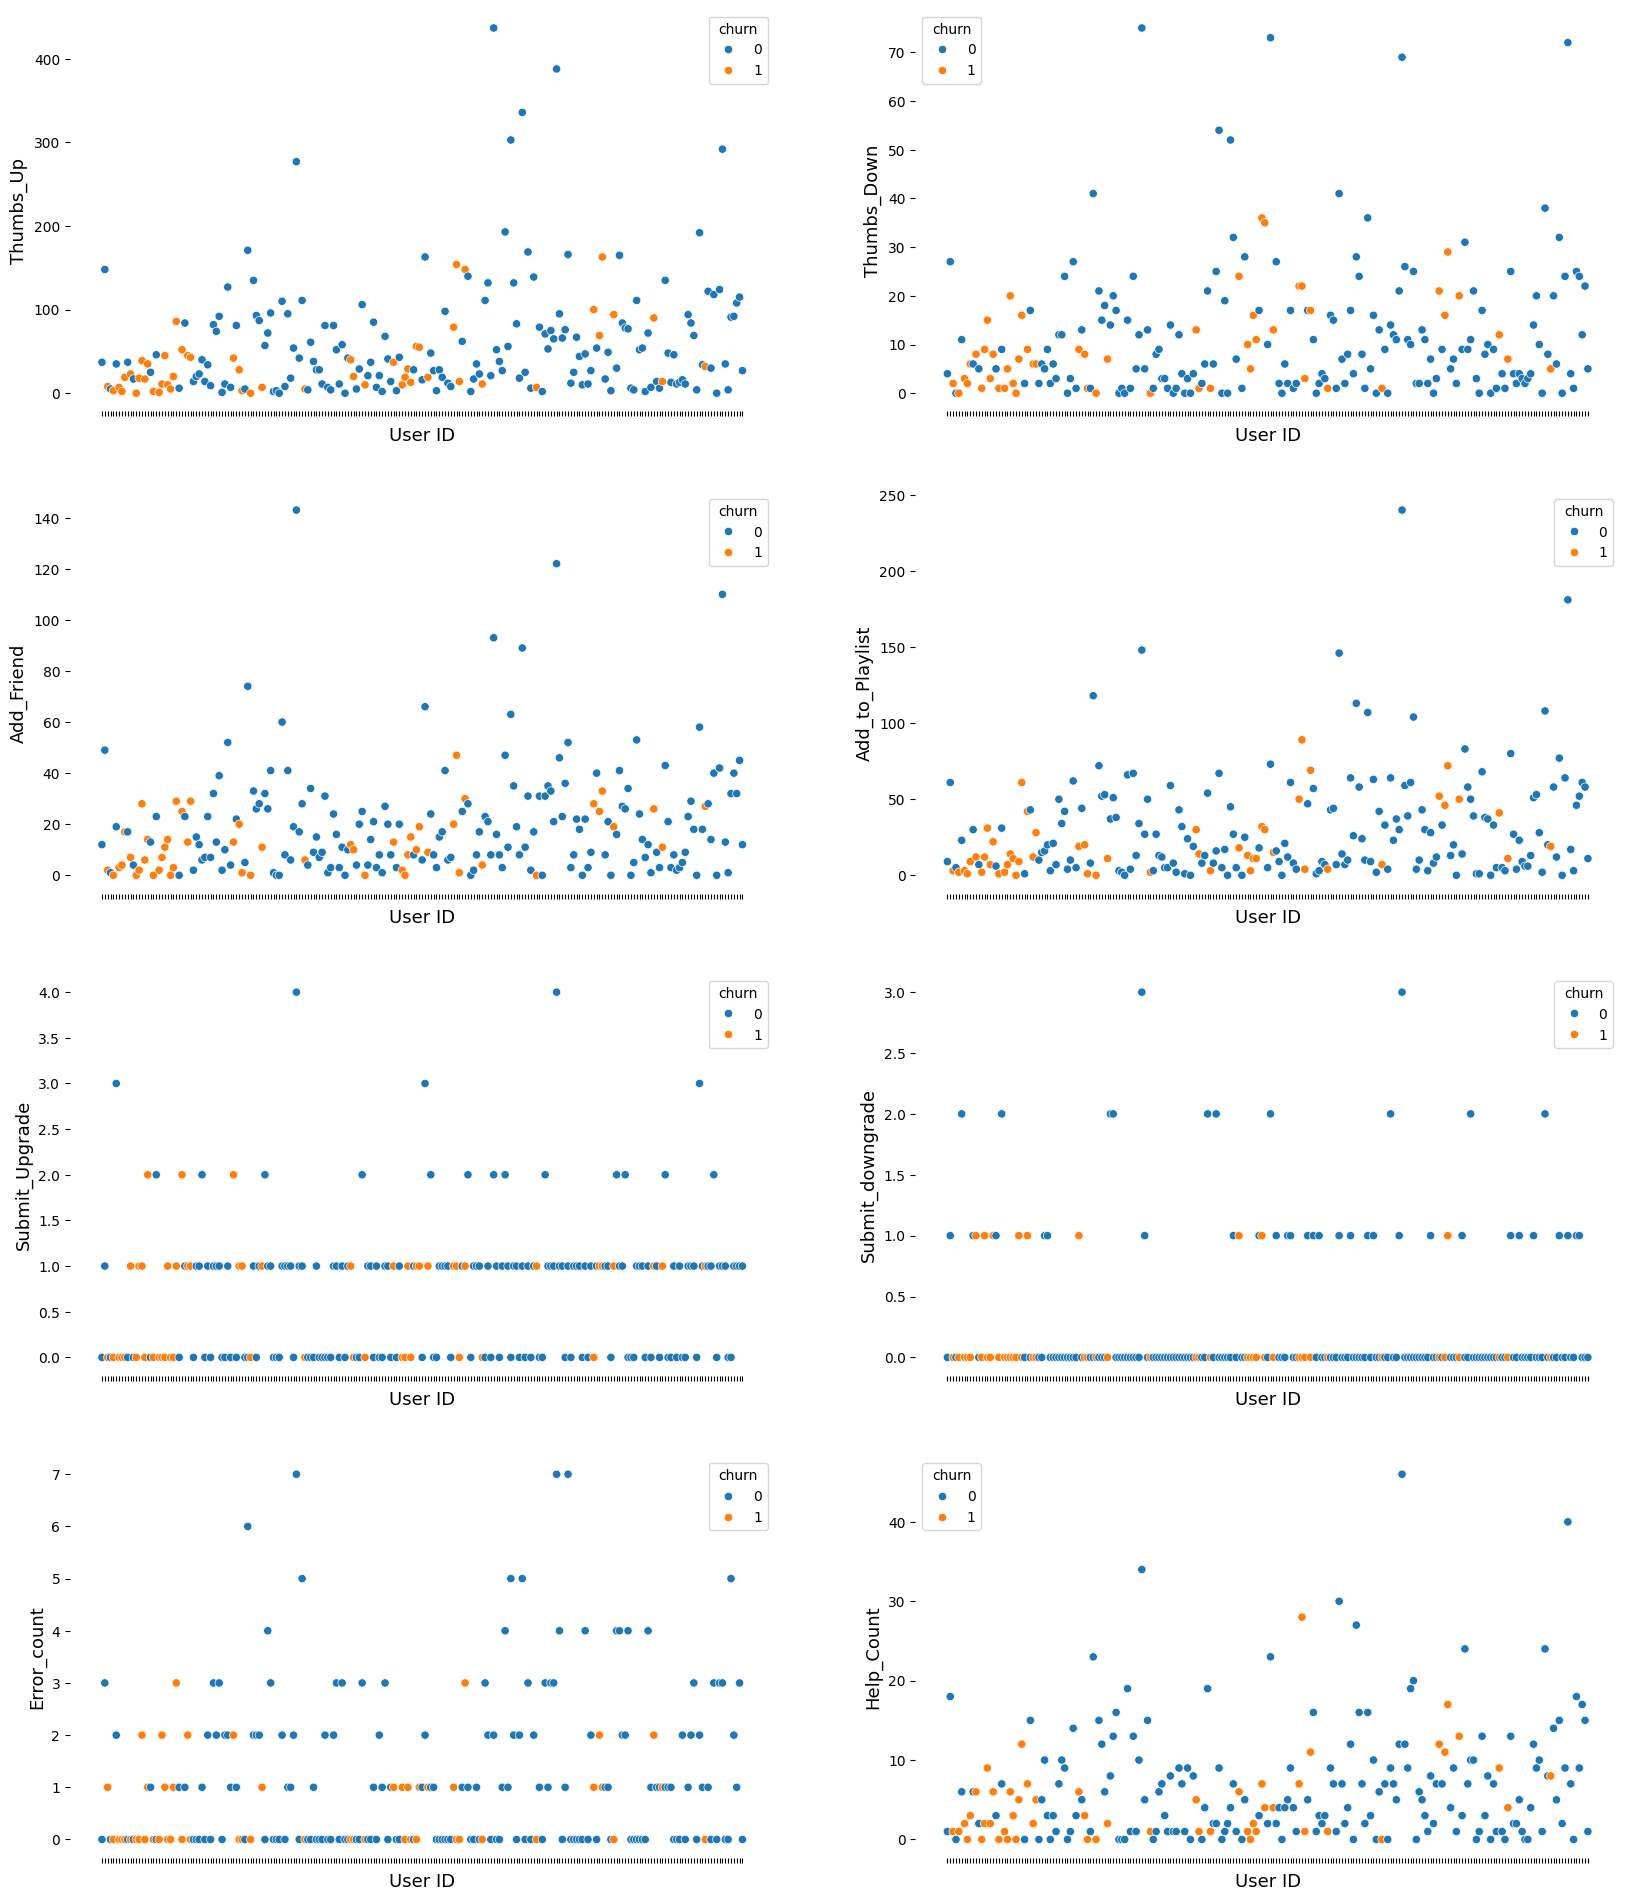

In [80]:
# Visualize the data

pd_page = churn_page.toPandas()

fig, axes = plt.subplots(4, 2, figsize=(20, 24))

# Define the features to plot
features = ['Thumbs_Up', 'Thumbs_Down', 'Add_Friend', 'Add_to_Playlist',
            'Submit_Upgrade', 'Submit_downgrade', 'Error_count', 'Help_Count']

# Loop through axes and features to create scatterplots
for ax, feature in zip(axes.flatten(), features):
    sns.scatterplot(ax=ax, data=pd_page, x='userId', y=feature, hue='churn')
    ax.set_xlabel('User ID', fontsize=13)  # Set x-axis label font size
    ax.set_ylabel(feature, fontsize=13)  # Set y-axis label font size
    
# Remove xticklabels for all subplots
for ax in axes.flatten():
    ax.set_xticklabels([])  # Fixed the iteration


sns.despine(bottom=True, left=True);

We notice that churners have values in the thumbs down chart higher than the thumbs up chart, for the remaining charts, the variance is not apparent given that the total number of churners is far less than non-churners.

# Feature Engineering

Since each user in our data has multiple rows, we need to aggregate the data so that every user has only one row before modelling the data. Let's explore each column to see if we will include or exclude it from the final version we will model.

In [81]:
# artist
print(df.select(['artist']).dropDuplicates().count())
df.select(['artist']).dropDuplicates().take(5)

17656


[Row(artist='The Black Keys'),
 Row(artist='Silverstein'),
 Row(artist='Kate Nash'),
 Row(artist='Yann Tiersen'),
 Row(artist="Jane's Addiction")]

In [82]:
# auth
print(df.select(['auth']).dropDuplicates().count())
df.select(['auth']).dropDuplicates().take(5)

2


[Row(auth='Cancelled'), Row(auth='Logged In')]

In [83]:
# itemInSession
print(df.select(['itemInSession']).dropDuplicates().count())
df.select(['itemInSession']).dropDuplicates().take(5)

1311


[Row(itemInSession=26),
 Row(itemInSession=29),
 Row(itemInSession=474),
 Row(itemInSession=964),
 Row(itemInSession=65)]

In [84]:
# length
print(df.select(['length']).dropDuplicates().count())
df.select(['length']).dropDuplicates().take(5)

14866


[Row(length=200.75057),
 Row(length=317.30893),
 Row(length=260.28363),
 Row(length=241.94567),
 Row(length=216.47628)]

In [85]:
# level
print(df.select(['level']).dropDuplicates().count())
df.select(['level']).dropDuplicates().take(5)

2


[Row(level='free'), Row(level='paid')]

In [86]:
# method
print(df.select(['method']).dropDuplicates().count())
df.select(['method']).dropDuplicates().take(5)

2


[Row(method='PUT'), Row(method='GET')]

In [87]:
# page
print(df.select(['page']).dropDuplicates().count())
df.select(['page']).dropDuplicates().take(5)

19


[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade')]

In [88]:
# sessionId
print(df.select(['sessionId']).dropDuplicates().count())
df.select(['sessionId']).dropDuplicates().take(5)

2312


[Row(sessionId=29),
 Row(sessionId=26),
 Row(sessionId=474),
 Row(sessionId=964),
 Row(sessionId=1697)]

In [89]:
# song
print(df.select(['song']).dropDuplicates().count())
df.select(['song']).dropDuplicates().take(5)

58481


[Row(song='Never Gonna Be Alone (Album Version)'),
 Row(song='TULENLIEKKI'),
 Row(song='Underwaterboys'),
 Row(song='Saor (Free)/News From Nowhere'),
 Row(song='New E')]

In [90]:
# status
print(df.select(['status']).dropDuplicates().count())
df.select(['status']).dropDuplicates().take(5)

3


[Row(status=307), Row(status=404), Row(status=200)]

In [91]:
print(df.columns)

['artist', 'auth', 'gender', 'itemInSession', 'length', 'level', 'location', 'method', 'page', 'sessionId', 'song', 'status', 'userId', 'timestamp', 'registration', 'Duration', 'churn', 'hour', 'dow', 'OperatingSystem', 'Browser']


According to the above, I believe that the below columns are related to the user's choices (song name, artist name...etc) or the normal usage behaviour (i.e. sign in, sign out...etc) that won't impact churn:

[artist, auth, location, method, sessionId, song, status, timestamp, registration, hour, dow]

So I will drop them, and proceed with aggregating the data of the remaining columns

In [92]:
# Select features to keep
columns_to_drop = ['artist', 'auth', 'itemInSession', 'location', 'method', 'sessionId', 'song', 'status', 'timestamp', 'registration', 'hour',
                   'dow']

df_fe = df.drop('artist', 'auth', 'itemInSession', 'location', 'method', 'sessionId', 'song', 'status', 'timestamp', 'registration', 'hour',
               'dow')
df_fe.head()

Row(gender='M', length=None, level='paid', page='Downgrade', userId='10', Duration=51.76265046296297, churn=0, OperatingSystem='Macintosh', Browser='Chrome')

Now let's merge all the data

In [93]:
# Check duration dataframe created earlier
sub_duration.show(5)

+------+-----+------------------+
|userId|churn|          duration|
+------+-----+------------------+
|    10|    0| 51.76265046296297|
|   100|    0| 64.87377314814815|
|100001|    1| 44.80021990740741|
|100002|    0|160.47207175925925|
|100003|    1|22.748113425925926|
+------+-----+------------------+
only showing top 5 rows



In [94]:
# Aggregate length
df_length = df.select(df.userId, df.length).groupBy(df.userId).agg({"length":"avg"})
df_length.show(5)

+------+------------------+
|userId|       avg(length)|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913750000006|
|    51|247.88055082899118|
|   124|248.17653659965674|
+------+------------------+
only showing top 5 rows



Now let's extract "level", "churn" and "gender" unique values per user. For Level, let's sort descendingly according to timestamp and then remove duplicates to get the latest status, since customers can switch level multiple times

In [95]:
# Extract latest supscription level per user
df_level = df.select(df.userId, df.level, df.gender, df.OperatingSystem, df.Browser).orderBy(desc(df.timestamp)).dropDuplicates(['userId'])
df_level.show(5)

+------+-----+------+---------------+-------+
|userId|level|gender|OperatingSystem|Browser|
+------+-----+------+---------------+-------+
|    10| paid|     M|      Macintosh| Chrome|
|   100| paid|     M| Windows NT 6.1|Firefox|
|100001| free|     F|      Macintosh| Chrome|
|100002| paid|     F| Windows NT 6.1|Firefox|
|100003| free|     F| Windows NT 6.1|Firefox|
+------+-----+------+---------------+-------+
only showing top 5 rows



We noticed earlier that we have missing values in the "Browser" column. Let's fill it with "Unknown" string

In [96]:
df_level = df_level.withColumn("Browser", when((col("Browser") == "") , "unknown").otherwise(col("Browser")))

In [97]:
# Check unique browser values
df_level.select(df_level.Browser).dropDuplicates().show(5)

+-------+
|Browser|
+-------+
|unknown|
|Firefox|
|Version|
| Chrome|
+-------+



Let's now merge all datasets

In [98]:
df_fin1 = sub_duration.join(df_length, on="userId", how='left')
df_fin2 = df_fin1.join(df_level, on="userId", how='left')
df_fin3 = df_fin2.join(df_page, on="userId", how='left')
df_fin4 = df_fin3.fillna(0)
df_fin4.take(1)

[Row(userId='10', churn=0, duration=51.76265046296297, avg(length)=247.94408991084703, level='paid', gender='M', OperatingSystem='Macintosh', Browser='Chrome', Submit_downgrade=0, Thumbs_Down=4, Add_to_Playlist=9, Add_Friend=12, Thumbs_Up=37, Help_Count=1, Error_count=0, Submit_Upgrade=0)]

In [99]:
# Perform encoding for categorical columns

indexer1 = StringIndexer(inputCol="level", outputCol="level_enc")
indexer2 = StringIndexer(inputCol="gender", outputCol="gender_enc")
indexer3 = StringIndexer(inputCol="OperatingSystem", outputCol="OperatingSystem_enc")
indexer4 = StringIndexer(inputCol="Browser", outputCol="Browser_enc")


df_fe1 = indexer1.fit(df_fin4).transform(df_fin4)
df_fe2 = indexer2.fit(df_fe1).transform(df_fe1)
df_fe3 = indexer3.fit(df_fe2).transform(df_fe2)
df_fe4 = indexer4.fit(df_fe3).transform(df_fe3)

df_fe4.take(1)

[Row(userId='10', churn=0, duration=51.76265046296297, avg(length)=247.94408991084703, level='paid', gender='M', OperatingSystem='Macintosh', Browser='Chrome', Submit_downgrade=0, Thumbs_Down=4, Add_to_Playlist=9, Add_Friend=12, Thumbs_Up=37, Help_Count=1, Error_count=0, Submit_Upgrade=0, level_enc=0.0, gender_enc=0.0, OperatingSystem_enc=0.0, Browser_enc=0.0)]

In [100]:
# Drop categorical colums
df_final = df_fe4.drop('level', 'gender', 'OperatingSystem', 'Browser')
df_final.take(1)

[Row(userId='10', churn=0, duration=51.76265046296297, avg(length)=247.94408991084703, Submit_downgrade=0, Thumbs_Down=4, Add_to_Playlist=9, Add_Friend=12, Thumbs_Up=37, Help_Count=1, Error_count=0, Submit_Upgrade=0, level_enc=0.0, gender_enc=0.0, OperatingSystem_enc=0.0, Browser_enc=0.0)]

In [101]:
print(df_final.columns)

['userId', 'churn', 'duration', 'avg(length)', 'Submit_downgrade', 'Thumbs_Down', 'Add_to_Playlist', 'Add_Friend', 'Thumbs_Up', 'Help_Count', 'Error_count', 'Submit_Upgrade', 'level_enc', 'gender_enc', 'OperatingSystem_enc', 'Browser_enc']


In [102]:
# Vectorize our data
feat_assembler = VectorAssembler(inputCols = ['duration', 'avg(length)', 'Submit_downgrade', 'Thumbs_Down', 'Add_to_Playlist', 
                                              'Add_Friend', 'Thumbs_Up', 'Help_Count', 'Error_count', 'Submit_Upgrade', 
                                              'level_enc', 'gender_enc', 'OperatingSystem_enc', 'Browser_enc'], 
                                outputCol = "features")
feat_df = feat_assembler.transform(df_final)
model_df = feat_df.select(col("churn").alias("label"), col("features"))

In [103]:
model_df.take(2)

[Row(label=0, features=SparseVector(14, {0: 51.7627, 1: 247.9441, 3: 4.0, 4: 9.0, 5: 12.0, 6: 37.0, 7: 1.0})),
 Row(label=0, features=DenseVector([64.8738, 250.8866, 1.0, 27.0, 61.0, 49.0, 148.0, 18.0, 3.0, 1.0, 0.0, 0.0, 1.0, 1.0]))]

# Modeling

In [104]:
# Split the data into train, test, and validation sets

train, validation, test = model_df.randomSplit([0.7, 0.15, 0.15], seed=42)

I'm going to use tree-based models because they are generally known for performing well with imbalanced datasets , so there will be no need to scale our data since tree-based models work using entropy. We will use f1-score for performance evaluation since the dataset is imbalanced.

In [105]:
# Instanciate models

gb = GBTClassifier(featuresCol = 'features', labelCol = 'label', seed=0, maxIter=50)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=0, numTrees=100)
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', seed=0)

In [106]:
# gb
gb_model = gb.fit(train)
gb_v_predictions = gb_model.transform(validation)

gb_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

gb_f1_score = gb_evaluator.evaluate(gb_v_predictions)
print("GB Model F1_Score is {}".format(gb_f1_score))

GB Model F1_Score is 0.6131954056482357


In [107]:
# rf
rf_model = rf.fit(train)
rf_v_predictions = rf_model.transform(validation)

rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

rf_f1_score = rf_evaluator.evaluate(rf_v_predictions)
print("RF Model F1_Score is {}".format(rf_f1_score))

RF Model F1_Score is 0.7593307593307594


In [108]:
# dt
dt_model = dt.fit(train)
dt_v_predictions = dt_model.transform(validation)

dt_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

dt_f1_score = dt_evaluator.evaluate(dt_v_predictions)
print("dt Model F1_Score is {}".format(dt_f1_score))

dt Model F1_Score is 0.6117677486098537


Best performance resulted from using Random Forest, let's use it.

In [109]:
# Perform Gridsearch
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100])  # Number of trees
paramGrid = paramGrid.addGrid(rf.maxDepth, [5, 10, 15])  # Maximum depth of trees
paramGrid = paramGrid.build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=rf_evaluator,
                          numFolds=3)

In [110]:
# Perform cross validation
cv_model = crossval.fit(train)

In [111]:
best_rf_model = cv_model.bestModel
rf_predictions = best_rf_model.transform(validation)

rf_f1_score = rf_evaluator.evaluate(rf_predictions)
print(f"Best RF Model F1-Score: {rf_f1_score}")

Best RF Model F1-Score: 0.7593307593307594


It seems that the parameters I used in Gridsearch decreased F1-score. So I will use the initial model with default parameters "rf_model"

In [112]:
# Use the best model to make predictions on the test set
test_predictions = rf_model.transform(test)

# Evaluate the final model performance on the test set
test_f1_score = rf_evaluator.evaluate(test_predictions)

print(f"Random Forest Final Test Set F1-Score: {np.round(test_f1_score*100, 2)}%")

Random Forest Final Test Set F1-Score: 76.41%


In [113]:
# Print confusion matrix

# Select only prediction and label columns
predictionAndLabels = test_predictions.select(col("prediction").cast(FloatType()), 
                        col("label").cast(FloatType()))
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

Confusion Matrix:
 [[19.  1.]
 [ 4.  1.]]


In [114]:
# Extract feature importances
importances = rf_model.featureImportances.toArray()

# Convert to a Pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature_Index": range(len(importances)),
    "Importance": importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

In [115]:
# Map feature importance to feature names

feature_cols  = ['duration', 'avg(length)', 'Submit_downgrade', 'Thumbs_Down', 'Add_to_Playlist', 'Add_Friend',
                                              'Thumbs_Up', 'Help_Count', 'Error_count', 'Submit_Upgrade', 
                                              'level_enc', 'gender_enc', 'OperatingSystem_enc', 'Browser_enc']

feature_importance_df["Feature_Name"] = feature_importance_df["Feature_Index"].apply(lambda i: feature_cols[i])

print(feature_importance_df)

    Feature_Index  Importance         Feature_Name
0               0    0.367168             duration
1               1    0.112309          avg(length)
5               5    0.091011           Add_Friend
3               3    0.080478          Thumbs_Down
6               6    0.077497            Thumbs_Up
4               4    0.072919      Add_to_Playlist
8               8    0.050463          Error_count
12             12    0.046600  OperatingSystem_enc
7               7    0.036201           Help_Count
13             13    0.022529          Browser_enc
11             11    0.015876           gender_enc
9               9    0.010998       Submit_Upgrade
10             10    0.009724            level_enc
2               2    0.006227     Submit_downgrade


It seems that the most 2 important features to predict churn are # subscription duration days and average song length. We can use this information to detect customers with high probability of churning and try to approach them with retention offers.

### Thank You